In [1]:
from dolfin import *
from ufl_legacy import le
import operator
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

/home/magister-nihili/miniconda3/envs/NEIM2/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):


# Spatial Refinements

In [2]:
# Q-Tensor parameters
n = 2
num_steps = 2000
T = 0.2
dt = T/num_steps
a = -0.3
b = -4.
c = 4.
M = 1.
L = 1.

# Parameters for electric field
R = 2.
eps2 = 0.5
eps3 = 0.01
eps1 = 2.5

# Parameters for convex splitting
beta1 = 8.
beta2 = 8.

In [3]:
# Create mesh
mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5, 0.5), 300, 300)

In [4]:
# some functions for the scheme
I = Constant(np.eye(n)) # identity matrix
Zero = 0 * I
Zero_func = 0*Function(FunctionSpace(mesh, "Lagrange", 1))

def dF1_dQ(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    result = beta1 * Q - b*(Q2 - 1/n * trQ2 * I) + beta2 * trQ2 * Q
    return result

def dF2_dQ(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    result = (beta1 - a) * Q + (beta2 - c) * trQ2 * Q
    return result

def F_tot(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    trQ3 = tr(Q2*Q)
    result = a/2 * trQ2 - b/3 * trQ3 + c/4 * trQ2**2
    return result

def tens(Q):
    """
    Make vector function into tensor
    """
    return as_tensor([[Q[0], Q[1]],
                      [Q[1], -1*Q[0]]])

def tens_hi(Q):
    return as_tensor([[Q[0], Q[1]],
                      [Zero_func, Zero_func]])

def tens_lo(Q):
    return as_tensor([[Zero_func, Zero_func],
                      [Q[0], Q[1]]])

# approximate Heaviside function
steepness = 5

def H_(x):
    return 1/np.pi * atan(steepness * x) + 0.5

def DH_(x):
    return 1/np.pi * steepness / (1 + (steepness * x)**2)

# truncation of one component to R/d, d=2
def TR_1D(x):
    return x * H_(R/2-x) * H_(R/2+x) + R/2*H_(x-R/2) - R/2*H_(-x-R/2)

# derivative of TR_1D
def calP_1D(x):
    return H_(R/2-x)*H_(R/2+x) - x*DH_(R/2-x)*H_(R/2+x) + x*H_(R/2-x)*DH_(R/2+x) + R/2*DH_(x-R/2) + R/2*DH_(-x-R/2)

# now if Q is a tensor
def TR(Q):
    return as_tensor([[TR_1D(Q[0, 0]), TR_1D(Q[0, 1])], 
                      [TR_1D(Q[1, 0]), TR_1D(Q[1, 1])]])

def calP(Q):
    return as_tensor([[calP_1D(Q[0, 0]), calP_1D(Q[0, 1])], 
                      [calP_1D(Q[1, 0]), calP_1D(Q[1, 1])]])

def calP_h(Q1, Q0):
    P11 = calP_1D(Q0[0, 0])
    P12 = calP_1D(Q0[0, 1])
    P21 = calP_1D(Q0[1, 0])
    P22 = calP_1D(Q0[1, 1])
    
    res = as_tensor([[P11, P12],
                      [P21, P22]])
    return res

def element_mult(A, B):
    return as_tensor([[A[0, 0] * B[0, 0], A[0, 1] * B[0, 1]], 
                      [A[1, 0] * B[1, 0], A[1, 1] * B[1, 1]]])

/home/magister-nihili/miniconda3/envs/NEIM2/lib/python3.9/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


### Initialize $Q_h^0$ and $u_h^0$

In [5]:
# initial conditions for the Q tensor
class InitialConditions(UserExpression):
    def eval(self, values, x):
        x, y = x[0], x[1]
        if np.isclose(x, -0.5) or np.isclose(x, 0.5) or np.isclose(y, -0.5) or np.isclose(y, 0.5):
            values[0] = 0.0
            values[1] = 0.0
        else:
            n0 = (x+0.5)*(x-0.5)*(y+0.5)*(y-0.5)
            n1 = (x+0.5)*(x-0.5)*(y+0.5)*(y-0.5)
            d = np.array([[n0], [n1]]) # director
            Q0 = d @ d.T - np.sum(d*d)/2.0 * np.eye(2) # Q tensor

            values[0] = Q0[0, 0]
            values[1] = Q0[0, 1]
    def value_shape(self):
        return (2,)

In [6]:
# initialize Q tensor at time 0
Q0 = Function(VectorFunctionSpace(mesh, "Lagrange", 1, dim=2))
Q_init = InitialConditions()
Q0.interpolate(Q_init)

# define uninitialized u0 and linear form to solve for u0
u_space = FunctionSpace(mesh, "Lagrange", 1)
u0 = Function(u_space)
v = TestFunction(u_space)

L_elliptic = inner(grad(u0) + eps2*TR(tens(Q0))*grad(u0) + eps3*div(tens(Q0)), grad(v))*dx

# define boundary condition for u0
t = 0.0
u_b = Expression(f'10*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
bc_u = DirichletBC(u_space, u_b, DomainBoundary())

# solve for u0
solve(L_elliptic == 0, u0, bc_u)

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.173e+02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.795e-13 (tol = 1.000e-10) r (rel) = 1.530e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


## Compute Reference Solution

In [6]:
class QTensorEquation(NonlinearProblem):
    def __init__(self, L, a, bcs):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
        self.bcs = bcs

    def F(self, b, x):
        assemble(self.L, tensor=b)
        for bc in self.bcs:
            bc.apply(b, x)

    def J(self, A, x):
        assemble(self.a, tensor=A)
        for bc in self.bcs:
            bc.apply(A)

In [8]:
Q_space = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim=2)
u_space = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = MixedElement(Q_space, u_space)
V = FunctionSpace(mesh, ME)

In [9]:
# Define trial and test functions
dQu = TrialFunction(V)
q, v = TestFunctions(V)
r, _ = TestFunctions(V)

# Define functions
Qu = Function(V)

# Split mixed functions
dQ, du = split(dQu)
Q, u = split(Qu)

In [10]:
# Weak statement of the equation
L_form = inner(tens(Q - Q0), tens(q))*dx\
    + M*L*dt/2*inner(grad(tens(Q+Q0)), grad(tens(q)))*dx\
    + M*dt*inner(dF1_dQ(tens(Q)), tens(q))*dx\
    - M*dt*inner(dF2_dQ(tens(Q0)), tens(q))*dx\
    - M*eps2*dt/2*(inner(element_mult(calP_h(tens(Q), tens(Q0)), outer(grad(u0), grad(u))) - (1/n)*tr(element_mult(calP_h(tens(Q), tens(Q0)), outer(grad(u0), grad(u))))*I, tens(q))*dx)\
    - M*eps3*dt/2*(inner(grad(u+u0), div(sym(tens_hi(q))))*dx - (1/n)*inner(grad(u+u0), grad(tr(tens(q))))*dx)\
    + dt*inner(grad(u) + eps2*TR(tens(Q))*grad(u) + eps3*div(tens(Q)), grad(v))*dx

a_form = derivative(L_form, Qu, dQu)

In [11]:
# boundary conditions for Q do not change
bc_Q = DirichletBC(V.sub(0), np.zeros(2), DomainBoundary())

# Store solutions and times
Q_array = Q0.vector()[:].reshape(-1, 2)
Q_11 = Q_array[:, 0]
Q_12 = Q_array[:, 1]
#solutions_Q = [np.array([[Q_11, Q_12], [Q_12, -Q_11]]).transpose(2, 0, 1)]
#solutions_u = [np.array(u0.vector()[:].reshape(-1, 1))]
times = [0.0]

u_b_expr = Expression('10*sin(omega*t + phase)*(x[0]+0.5)*sin(pi*x[1])',
                      degree=2, omega=2*np.pi, t=0.0, phase=0.2, pi=np.pi)
bc_u = DirichletBC(V.sub(1), u_b_expr, DomainBoundary())

problem = QTensorEquation(L_form, a_form, [bc_Q, bc_u])
solver = NewtonSolver()
solver.parameters["linear_solver"] = "gmres"
solver.parameters["preconditioner"] = "ilu"

assigner_Q = FunctionAssigner(Q0.function_space(), V.sub(0))
assigner_u = FunctionAssigner(u0.function_space(), V.sub(1))

t = 0.0
while (t < T):
    print(t)
    t += dt
    times.append(t)
    
    #u_b = Expression(f'10*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
    #bc_u = DirichletBC(V.sub(1), u_b, DomainBoundary())
    u_b_expr.t = t
    
    #problem = QTensorEquation(L_form, a_form, [bc_Q, bc_u])
    solver.solve(problem, Qu.vector())
    
    #Q_array = Qu.sub(0, deepcopy=True).vector()[:].reshape(-1, 2)
    #Q_11 = Q_array[:, 0]
    #Q_12 = Q_array[:, 1]
    
    #solutions_Q.append(np.array([[Q_11, Q_12], [Q_12, -Q_11]]).transpose(2, 0, 1))
    #solutions_u.append(np.array(Qu.sub(1, deepcopy=True).vector()[:].reshape(-1, 1)))
    
    #Q0.vector()[:] = np.ascontiguousarray(Qu.sub(0, deepcopy=True).vector()[:])
    #u0.vector()[:] = np.ascontiguousarray(Qu.sub(1, deepcopy=True).vector()[:])

    assigner_Q.assign(Q0, Qu.sub(0))
    assigner_u.assign(u0, Qu.sub(1))



0.0
Newton iteration 0: r (abs) = 3.728e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.553e-07 (tol = 1.000e-10) r (rel) = 4.164e-09 (tol = 1.000e-09)
0.0001Newton iteration 2: r (abs) = 1.556e-13 (tol = 1.000e-10) r (rel) = 4.173e-15 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 363 linear solver iterations.

Newton iteration 0: r (abs) = 1.152e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 2.249e-10 (tol = 1.000e-10) r (rel) = 1.953e-09 (tol = 1.000e-09)
0.0002Newton iteration 2: r (abs) = 4.015e-16 (tol = 1.000e-10) r (rel) = 3.486e-15 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 327 linear solver iterations.

Newton iteration 0: r (abs) = 1.152e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 2.200e-10 (tol = 1.000e-10) r (rel) = 1.910e-09 (tol = 1.000e-09)
0.00030000000000000003Newton iteration 2: r (abs) = 3.958e-16 (tol =

## Now errors compared to reference solution

In [12]:
# Q-Tensor parameters
num_steps = 200
T = 0.2
dt = T/num_steps

In [13]:
mesh_sizes = []
Q_L2_errors = []
Q_H1_errors = []
u_L2_errors = []
u_H1_errors = []

for num_grid_points in [10, 20, 40, 80]:
    # Create mesh
    mesh1 = RectangleMesh(Point(-0.5, -0.5), Point(0.5, 0.5), num_grid_points, num_grid_points)
    mesh_sizes.append(1/num_grid_points)

    # initialize Q tensor at time 0
    Q1 = Function(VectorFunctionSpace(mesh1, "Lagrange", 1, dim=2))
    Q_init = InitialConditions()
    Q1.interpolate(Q_init)
    
    # define uninitialized u0 and linear form to solve for u0
    u_space = FunctionSpace(mesh1, "Lagrange", 1)
    u1 = Function(u_space)
    v = TestFunction(u_space)
    
    L_elliptic = inner(grad(u1) + eps2*TR(tens(Q1))*grad(u1) + eps3*div(tens(Q1)), grad(v))*dx
    
    # define boundary condition for u0
    t = 0.0
    u_b = Expression(f'10*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
    bc_u = DirichletBC(u_space, u_b, DomainBoundary())
    
    # solve for u0
    solve(L_elliptic == 0, u1, bc_u)

    Q_space1 = VectorElement("Lagrange", mesh1.ufl_cell(), 1, dim=2)
    u_space1 = FiniteElement("Lagrange", mesh1.ufl_cell(), 1)
    ME1 = MixedElement(Q_space1, u_space1)
    V1 = FunctionSpace(mesh1, ME1)

    # Define trial and test functions
    dQu = TrialFunction(V1)
    q, v = TestFunctions(V1)
    r, _ = TestFunctions(V1)
    
    # Define functions
    Qu = Function(V1)
    
    # Split mixed functions
    dQ, du = split(dQu)
    Q, u = split(Qu)

    # Weak statement of the equation
    L_form = inner(tens(Q - Q1), tens(q))*dx\
        + M*L*dt/2*inner(grad(tens(Q+Q1)), grad(tens(q)))*dx\
        + M*dt*inner(dF1_dQ(tens(Q)), tens(q))*dx\
        - M*dt*inner(dF2_dQ(tens(Q1)), tens(q))*dx\
        - M*eps2*dt/2*(inner(element_mult(calP_h(tens(Q), tens(Q1)), outer(grad(u1), grad(u))) - (1/n)*tr(element_mult(calP_h(tens(Q), tens(Q1)), outer(grad(u1), grad(u))))*I, tens(q))*dx)\
        - M*eps3*dt/2*(inner(grad(u+u1), div(sym(tens_hi(q))))*dx - (1/n)*inner(grad(u+u1), grad(tr(tens(q))))*dx)\
        + dt*inner(grad(u) + eps2*TR(tens(Q))*grad(u) + eps3*div(tens(Q)), grad(v))*dx
    
    a_form = derivative(L_form, Qu, dQu)

    # boundary conditions for Q do not change
    bc_Q = DirichletBC(V1.sub(0), np.zeros(2), DomainBoundary())
    
    # Store solutions and times
    Q_array = Q1.vector()[:].reshape(-1, 2)
    Q_11 = Q_array[:, 0]
    Q_12 = Q_array[:, 1]
    solutions_Q_1 = [np.array([[Q_11, Q_12], [Q_12, -Q_11]]).transpose(2, 0, 1)]
    solutions_u_1 = [np.array(u0.vector()[:].reshape(-1, 1))]
    times_1 = [0.0]
    
    solver = NewtonSolver()
    
    t = 0.0
    while (t < T):
        print(t)
        t += dt
        times_1.append(t)
        
        u_b = Expression(f'10*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
        bc_u = DirichletBC(V1.sub(1), u_b, DomainBoundary())
        
        problem = QTensorEquation(L_form, a_form, [bc_Q, bc_u])
        solver.solve(problem, Qu.vector())
        
        Q_array = Qu.sub(0, deepcopy=True).vector()[:].reshape(-1, 2)
        Q_11 = Q_array[:, 0]
        Q_12 = Q_array[:, 1]
        
        solutions_Q_1.append(np.array([[Q_11, Q_12], [Q_12, -Q_11]]).transpose(2, 0, 1))
        solutions_u_1.append(np.array(Qu.sub(1, deepcopy=True).vector()[:].reshape(-1, 1)))
        
        Q1.vector()[:] = np.ascontiguousarray(Qu.sub(0, deepcopy=True).vector()[:])
        u1.vector()[:] = np.ascontiguousarray(Qu.sub(1, deepcopy=True).vector()[:])

    Q_L2_errors.append(errornorm(Q0, Q1, 'L2', mesh=mesh))
    Q_H1_errors.append(errornorm(Q0, Q1, 'H1', mesh=mesh))
    u_L2_errors.append(errornorm(u0, u1, 'L2', mesh=mesh))
    u_H1_errors.append(errornorm(u0, u1, 'H1', mesh=mesh))

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.040e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.257e-15 (tol = 1.000e-10) r (rel) = 1.597e-16 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
0.0
Newton iteration 0: r (abs) = 7.006e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.001e-06 (tol = 1.000e-10) r (rel) = 1.428e-07 (tol = 1.000e-09)
0.001
Newton iteration 2: r (abs) = 9.249e-14 (tol = 1.000e-10) r (rel) = 1.320e-14 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
Newton iteration 0: r (abs) = 2.102e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
0.002
Newton iteration 1: r (abs) = 1.878e-08 (tol = 1.000e-10) r (rel) = 8.934e-08 (tol = 1.000e-09)
Newt

In [14]:
print(mesh_sizes, Q_L2_errors, Q_H1_errors, u_L2_errors, u_H1_errors)

[0.1, 0.05, 0.025, 0.0125] [0.028532293022569922, 0.007704467869712622, 0.0022954877796012942, 0.0011907424629353032] [0.9551493615810126, 0.49378229042301813, 0.25969067557995823, 0.1402311067536731] [0.02962408477938076, 0.007554263138760124, 0.001854029937705354, 0.0004400734411232786] [1.8314515752682565, 0.9309178754576384, 0.48762641170096965, 0.26300296026047953]


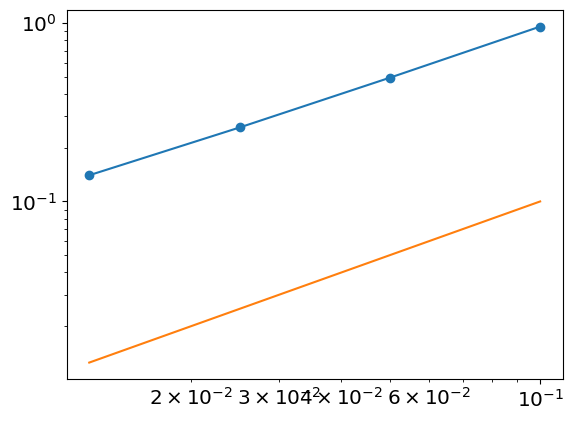

In [15]:
plt.loglog(mesh_sizes, Q_H1_errors)
plt.scatter(mesh_sizes, Q_H1_errors)
plt.loglog(mesh_sizes, mesh_sizes)
plt.show()

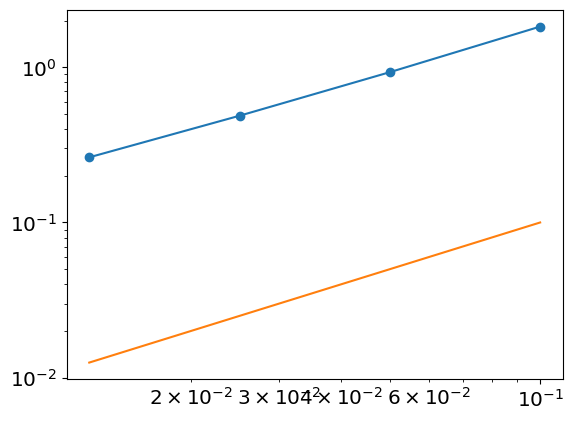

In [16]:
plt.loglog(mesh_sizes, u_H1_errors)
plt.scatter(mesh_sizes, u_H1_errors)
plt.loglog(mesh_sizes, mesh_sizes)
plt.show()

In [18]:
# Q H1 errors
(np.log(np.array(Q_H1_errors)[1:]) - np.log(np.array(Q_H1_errors)[:-1])) / (np.log(np.array(mesh_sizes)[1:]) - np.log(np.array(mesh_sizes))[:-1])

array([0.95185126, 0.92708088, 0.8889878 ])

In [19]:
# Q L2 errors
(np.log(np.array(Q_L2_errors)[1:]) - np.log(np.array(Q_L2_errors)[:-1])) / (np.log(np.array(mesh_sizes)[1:]) - np.log(np.array(mesh_sizes))[:-1])

array([1.88882847, 1.74689456, 0.94693933])

In [20]:
# u H1 errors
(np.log(np.array(u_H1_errors)[1:]) - np.log(np.array(u_H1_errors)[:-1])) / (np.log(np.array(mesh_sizes)[1:]) - np.log(np.array(mesh_sizes))[:-1])

array([0.97626175, 0.93287763, 0.89069723])

In [21]:
# u L2 errors
(np.log(np.array(u_L2_errors)[1:]) - np.log(np.array(u_L2_errors)[:-1])) / (np.log(np.array(mesh_sizes)[1:]) - np.log(np.array(mesh_sizes))[:-1])

array([1.97140764, 2.0266265 , 2.07484833])

# Time refinement

In [9]:
# Compute reference solution

num_grid_points = 200
num_steps = 4000

T = 0.2
dt = T/num_steps

# Create mesh
mesh2 = RectangleMesh(Point(-0.5, -0.5), Point(0.5, 0.5), num_grid_points, num_grid_points)
#mesh_sizes.append(dt)

# initialize Q tensor at time 0
Q2 = Function(VectorFunctionSpace(mesh2, "Lagrange", 1, dim=2))
Q_init = InitialConditions()
Q2.interpolate(Q_init)

# define uninitialized u0 and linear form to solve for u0
u_space = FunctionSpace(mesh2, "Lagrange", 1)
u2 = Function(u_space)
v = TestFunction(u_space)

L_elliptic = inner(grad(u2) + eps2*TR(tens(Q2))*grad(u2) + eps3*div(tens(Q2)), grad(v))*dx

# define boundary condition for u0
t = 0.0
u_b = Expression(f'0.1*({t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)#Expression(f'10*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
bc_u = DirichletBC(u_space, u_b, DomainBoundary())

# solve for u0
solve(L_elliptic == 0, u2, bc_u)

Q_space2 = VectorElement("Lagrange", mesh2.ufl_cell(), 1, dim=2)
u_space2 = FiniteElement("Lagrange", mesh2.ufl_cell(), 1)
ME2 = MixedElement(Q_space2, u_space2)
V2 = FunctionSpace(mesh2, ME2)

# Define trial and test functions
dQu = TrialFunction(V2)
q, v = TestFunctions(V2)
r, _ = TestFunctions(V2)

# Define functions
Qu = Function(V2)

# Split mixed functions
dQ, du = split(dQu)
Q, u = split(Qu)

# Weak statement of the equation
L_form = inner(tens(Q - Q2), tens(q))*dx\
    + M*L*dt/2*inner(grad(tens(Q+Q2)), grad(tens(q)))*dx\
    + M*dt*inner(dF1_dQ(tens(Q)), tens(q))*dx\
    - M*dt*inner(dF2_dQ(tens(Q2)), tens(q))*dx\
    - M*eps2*dt/2*(inner(element_mult(calP_h(tens(Q), tens(Q2)), outer(grad(u2), grad(u))) - (1/n)*tr(element_mult(calP_h(tens(Q), tens(Q2)), outer(grad(u2), grad(u))))*I, tens(q))*dx)\
    - M*eps3*dt/2*(inner(grad(u+u2), div(sym(tens_hi(q))))*dx - (1/n)*inner(grad(u+u2), grad(tr(tens(q))))*dx)\
    + dt*inner(grad(u) + eps2*TR(tens(Q))*grad(u) + eps3*div(tens(Q)), grad(v))*dx

a_form = derivative(L_form, Qu, dQu)

# boundary conditions for Q do not change
bc_Q = DirichletBC(V2.sub(0), np.zeros(2), DomainBoundary())

# Store solutions and times
times_2 = [0.0]

solver = NewtonSolver()

t = 0.0
while (t < T):
    print(t)
    t += dt
    times_2.append(t)
    
    u_b = Expression(f'0.1*({t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)#Expression(f'10*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
    bc_u = DirichletBC(V2.sub(1), u_b, DomainBoundary())
    
    problem = QTensorEquation(L_form, a_form, [bc_Q, bc_u])
    solver.solve(problem, Qu.vector())
                    
    Q2.vector()[:] = np.ascontiguousarray(Qu.sub(0, deepcopy=True).vector()[:])
    u2.vector()[:] = np.ascontiguousarray(Qu.sub(1, deepcopy=True).vector()[:])

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.785e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.392e-16 (tol = 1.000e-10) r (rel) = 5.000e-16 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
0.0
Newton iteration 0: r (abs) = 1.528e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 8.035e-11 (tol = 1.000e-10) r (rel) = 5.258e-10 (tol = 1.000e-09)
Newton solver finished in 1 iterations and 1 linear solver iterations.
5e-05
Newton iteration 0: r (abs) = 3.819e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.574e-16 (tol = 1.000e-10) r (rel) = 4.121e-12 (tol = 1.000e-09)
Newton solver finished in 1 iterations and 1 linear solver iterations.
0.0001
Newton iteration 0: r (abs) 

In [10]:
mesh_sizes = []
Q_L2_errors = []
Q_H1_errors = []
u_L2_errors = []
u_H1_errors = []

num_grid_points = 50#150

for num_steps in [40, 80, 160, 320]:
    T = 0.2
    dt = T/num_steps
    
    # Create mesh
    mesh1 = RectangleMesh(Point(-0.5, -0.5), Point(0.5, 0.5), num_grid_points, num_grid_points)
    mesh_sizes.append(dt)

    # initialize Q tensor at time 0
    Q1 = Function(VectorFunctionSpace(mesh1, "Lagrange", 1, dim=2))
    Q_init = InitialConditions()
    Q1.interpolate(Q_init)
    
    # define uninitialized u0 and linear form to solve for u0
    u_space = FunctionSpace(mesh1, "Lagrange", 1)
    u1 = Function(u_space)
    v = TestFunction(u_space)
    
    L_elliptic = inner(grad(u1) + eps2*TR(tens(Q1))*grad(u1) + eps3*div(tens(Q1)), grad(v))*dx
    
    # define boundary condition for u0
    t = 0.0
    u_b = Expression(f'0.1*({t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)#Expression(f'10*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
    bc_u = DirichletBC(u_space, u_b, DomainBoundary())
    
    # solve for u0
    solve(L_elliptic == 0, u1, bc_u)

    Q_space1 = VectorElement("Lagrange", mesh1.ufl_cell(), 1, dim=2)
    u_space1 = FiniteElement("Lagrange", mesh1.ufl_cell(), 1)
    ME1 = MixedElement(Q_space1, u_space1)
    V1 = FunctionSpace(mesh1, ME1)

    # Define trial and test functions
    dQu = TrialFunction(V1)
    q, v = TestFunctions(V1)
    r, _ = TestFunctions(V1)
    
    # Define functions
    Qu = Function(V1)
    
    # Split mixed functions
    dQ, du = split(dQu)
    Q, u = split(Qu)

    # Weak statement of the equation
    L_form = inner(tens(Q - Q1), tens(q))*dx\
        + M*L*dt/2*inner(grad(tens(Q+Q1)), grad(tens(q)))*dx\
        + M*dt*inner(dF1_dQ(tens(Q)), tens(q))*dx\
        - M*dt*inner(dF2_dQ(tens(Q1)), tens(q))*dx\
        - M*eps2*dt/2*(inner(element_mult(calP_h(tens(Q), tens(Q1)), outer(grad(u1), grad(u))) - (1/n)*tr(element_mult(calP_h(tens(Q), tens(Q1)), outer(grad(u1), grad(u))))*I, tens(q))*dx)\
        - M*eps3*dt/2*(inner(grad(u+u1), div(sym(tens_hi(q))))*dx - (1/n)*inner(grad(u+u1), grad(tr(tens(q))))*dx)\
        + dt*inner(grad(u) + eps2*TR(tens(Q))*grad(u) + eps3*div(tens(Q)), grad(v))*dx
    
    a_form = derivative(L_form, Qu, dQu)

    # boundary conditions for Q do not change
    bc_Q = DirichletBC(V1.sub(0), np.zeros(2), DomainBoundary())
    
    # Store solutions and times
    times_1 = [0.0]
    
    solver = NewtonSolver()
    
    t = 0.0
    while (t < T):
        print(t)
        t += dt
        times_1.append(t)
        
        u_b = Expression(f'0.1*({t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)#Expression(f'10*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
        bc_u = DirichletBC(V1.sub(1), u_b, DomainBoundary())
        
        problem = QTensorEquation(L_form, a_form, [bc_Q, bc_u])
        solver.solve(problem, Qu.vector())
                        
        Q1.vector()[:] = np.ascontiguousarray(Qu.sub(0, deepcopy=True).vector()[:])
        u1.vector()[:] = np.ascontiguousarray(Qu.sub(1, deepcopy=True).vector()[:])

    Q_L2_errors.append(errornorm(Q2, Q1, 'L2', mesh=mesh2))
    Q_H1_errors.append(errornorm(Q2, Q1, 'H1', mesh=mesh2))
    u_L2_errors.append(errornorm(u2, u1, 'L2', mesh=mesh2))
    u_H1_errors.append(errornorm(u2, u1, 'H1', mesh=mesh2))

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.785e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.392e-16 (tol = 1.000e-10) r (rel) = 5.000e-16 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
0.0
Newton iteration 0: r (abs) = 1.566e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 7.135e-09 (tol = 1.000e-10) r (rel) = 4.557e-08 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 3.800e-18 (tol = 1.000e-10) r (rel) = 2.427e-17 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
0.005
Newton iteration 0: r (abs) = 3.819e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 2.617e-11 (tol = 1.000e-10) r (rel) = 6.853e-09 (tol = 1.000e-09)
Newton sol

In [11]:
print(mesh_sizes, Q_L2_errors, Q_H1_errors, u_L2_errors, u_H1_errors)

[0.005, 0.0025, 0.00125, 0.000625] [5.209780504443569e-06, 2.574044137777523e-06, 1.2722868134353112e-06, 2.0705109420703538e-07] [2.4671558057998678e-05, 1.1728391055693058e-05, 5.796896998389317e-06, 9.493578282523404e-07] [1.8100519746569822e-06, 1.811961499270019e-06, 1.8129055867025172e-06, 2.085927612931916e-05] [7.223957754010545e-06, 7.223710419874947e-06, 7.223772993264384e-06, 8.307547006712516e-05]


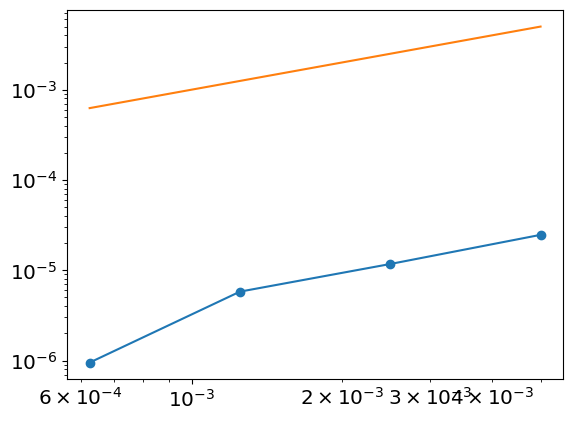

In [12]:
plt.loglog(mesh_sizes, Q_H1_errors)
plt.scatter(mesh_sizes, Q_H1_errors)
plt.loglog(mesh_sizes, np.array(mesh_sizes))
plt.show()

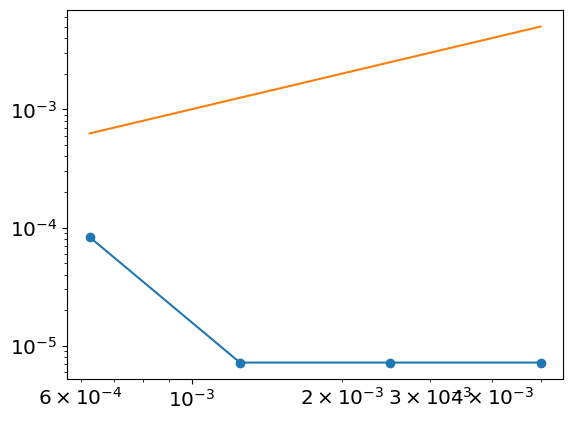

In [13]:
plt.loglog(mesh_sizes, u_H1_errors)
plt.scatter(mesh_sizes, u_H1_errors)
plt.loglog(mesh_sizes, mesh_sizes)
plt.show()

In [14]:
# Q H1 errors
(np.log(np.array(Q_H1_errors)[1:]) - np.log(np.array(Q_H1_errors)[:-1])) / (np.log(np.array(mesh_sizes)[1:]) - np.log(np.array(mesh_sizes))[:-1])

array([1.07284371, 1.01665236, 2.61025698])

In [15]:
# Q L2 errors
(np.log(np.array(Q_L2_errors)[1:]) - np.log(np.array(Q_L2_errors)[:-1])) / (np.log(np.array(mesh_sizes)[1:]) - np.log(np.array(mesh_sizes))[:-1])

array([1.0171858 , 1.01661286, 2.6193652 ])

In [16]:
# u H1 errors
(np.log(np.array(u_H1_errors)[1:]) - np.log(np.array(u_H1_errors)[:-1])) / (np.log(np.array(mesh_sizes)[1:]) - np.log(np.array(mesh_sizes))[:-1])

array([ 4.93958923e-05, -1.24968918e-05, -3.52359809e+00])

In [17]:
# u L2 errors
(np.log(np.array(u_L2_errors)[1:]) - np.log(np.array(u_L2_errors)[:-1])) / (np.log(np.array(mesh_sizes)[1:]) - np.log(np.array(mesh_sizes))[:-1])

array([-1.52117708e-03, -7.51492541e-04, -3.52431339e+00])